## Importing and Preparing Data

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb 23 14:20:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
# Source for Import Code: https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras.utils import plot_model

root = '/content/drive/My Drive/'
np.random.seed(2016)
split_random_state = 7
split = 0.8

def load_numeric_training(standardize=True):
    # Read data from the CSV file
    data = pd.read_csv('/content/drive/My Drive/train.csv',error_bad_lines=False)
    ID = data.pop('id')
    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    le = LabelEncoder()
    y = le.fit(y).transform(y)
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values
    return ID, X, y, mapping


def load_numeric_test(standardize=True):
    test = pd.read_csv('/content/drive/My Drive/test.csv', error_bad_lines=False)
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test

def resize_img(img, max_dim=224):
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

def load_image_data(ids, max_dim=224, center=True):
    X = np.empty((len(ids), max_dim, max_dim, 1))
    for i, idee in enumerate(ids):
        path = "/content/drive/My Drive/LeafClassification/%s.jpg" % (str(idee))
        x = resize_img(load_img(path, grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        length = x.shape[0]
        width = x.shape[1]
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        X[i, h1:h2, w1:w2, 0:1] = x
    return np.around(X / 255.0)

def load_train_data(split=split, random_state=None):
    # Load the pre-extracted features
    ID, X_num_tr, y, mapping = load_numeric_training()
    X_img_tr = load_image_data(ID)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val), mapping

def load_test_data():
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val), mapping = load_train_data(random_state=split_random_state)
print('Training data loaded!')

no_of_classes = len(np.unique(y_tr, axis=0))
number_of_features = X_num_tr.shape[1]

X_num_full = np.concatenate((X_num_tr, X_num_val), axis =0)
X_img_full = np.concatenate((X_img_tr, X_img_val), axis =0)
y_full = np.concatenate((y_tr, y_val), axis =0)

# reverse the mapping dictionairy
mapping2 = {v: k for k, v in mapping.items()}

ID_te, X_num_te, X_img_te = load_test_data()

Using TensorFlow backend.


Loading the training data...


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Training data loaded!


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


## Fully Connected Model






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 792 samples, validate on 198 samples
Epoch 1/50





792/792 [==============================] - 9s 12ms/step - loss: 2.4981 - acc: 0.5164 - val_loss: 0.6420 - val_acc: 0.8636
Epoch 2/50
792/792 [==============================] - 0s 114us/step - loss: 0.2485 - acc: 0.9394 - val_loss: 0.1795 - val_acc: 0.9394
Epoch 3/50
792/792 [==============================] - 0s 114us/step - loss: 0.0399 - acc: 0.9899 - val_loss: 0.0890 - val_acc: 0.9848
Epoch 4/50
792/792 [==============================] - 0s 103us/step - loss: 0.0140 - acc: 0.9987 - val_loss: 0.0610 - val_acc: 0.9848
Epoch 5/50
792/792 [==============================] - 0s 106us/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.0697 - val_acc: 0.9798
Epoch 6/50
792/792 [==============================] - 0s 102us/step - loss: 0.0194 - acc: 0.9962 - val_loss: 0.0436 - val_acc: 0.9949
Epoch 7/50
792/792 [========================

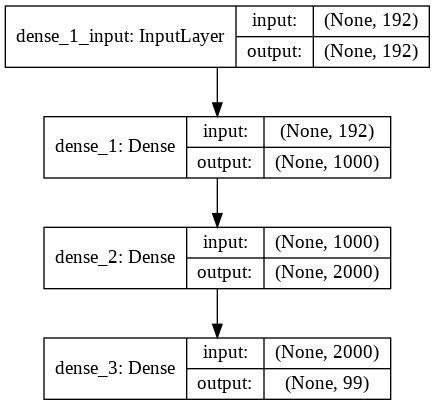

In [3]:

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History
import sklearn

seed = 5
history1 = History()
fully_conn1 = Sequential()

fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
fully_conn1.add(Dense(2000, activation='relu'))
fully_conn1.add(Dense(no_of_classes, activation='softmax'))

fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 50, 
                verbose=1, 
                validation_data=(X_num_val, y_val), 
                callbacks=[history1])

pred_fully_con1 = fully_conn1.predict(X_num_val)

print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
plot_model(fully_conn1, show_shapes = True)

### Hyperparameter-tuning with Gridsearch

---



---



In [0]:
# Load libraries
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

no_of_classes = len(np.unique(y_tr, axis=0))
number_of_features = X_num_tr.shape[1]

# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, activation_function_1='tanh', n_dense_1 = 1000, n_dense_2=1000, optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(n_dense_1, input_dim=number_of_features, activation=activation_function_1))
	model.add(Dropout(dropout_rate))
	model.add(Dense(n_dense_2, activation='relu'))
	model.add(Dropout(dropout_rate))
	model.add(Dense(no_of_classes, activation='softmax'))
	# Compile model
	model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fix random seed for reproducibility
seed = 7
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search dropout rate
dropout_rate = [0.0, 0.15, 0.3]
batch_size = [8, 16, 32]
n_dense_1 = [500, 1000, 1500]
n_dense_2 = [500, 1000, 1500]
activation_function_1 = ['tanh', 'relu']


epoch = 10

param_grid = dict(n_dense_1 =n_dense_1, 
                  n_dense_2 =n_dense_2, 
                  dropout_rate = dropout_rate, 
                  activation_function_1 = activation_function_1, 
                  batch_size = batch_size)

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
										cv=3, 
										return_train_score=True)

grid_result = grid.fit(X_num_tr, y_tr, 
                       verbose = 1, 
											 epochs = 5, 
											 validation_data=(X_num_val, y_val))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Train on 528 samples, validate on 198 samples
Epoch 1/5
528/528 [==============================] - 0s 795us/step - loss: 2.5594 - acc: 0.4830 - val_loss: 0.7244 - val_acc: 0.8737
Epoch 2/5
528/528 [==============================] - 0s 379us/step - loss: 0.2056 - acc: 0.9697 - val_loss: 0.2645 - val_acc: 0.9495
Epoch 3/5
528/528 [==============================] - 0s 359us/step - loss: 0.0604 - acc: 0.9924 - val_loss: 0.1904 - val_acc: 0.9646
Epoch 4/5
528/528 [==============================] - 0s 377us/step - loss: 0.0346 - acc: 0.9962 - val_loss: 0.1660 - val_acc: 0.9646
Epoch 5/5
528/528 [==============================] - 0s 362us/step - loss: 0.0273 - acc: 0.9943 - val_loss: 0.1465 - val_acc: 0.9697
Train on 528 samples, validate on 198 samples
Epoch 1/5
528/528 [==============================] - 1s 949us/step - loss: 2.7526 - acc: 0.4545 - val_loss: 0.7497 - val_acc: 0.8030
Epoch 2/5
528/528 [==============================] - 0s 419us/step - loss: 0.2608 - acc: 0.9621 - val_loss: 0.

In [0]:
# Source for Function: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
import matplotlib.pyplot as plt
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [0]:
plot_search_results(grid)

# Impact of Learning Rates



In this section we will fit our dense model with diverse learning rates configuration, in order to check its impact.

### Learning Rate Dynamics

In [0]:
# study of learning rate on accuracy 
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from matplotlib import pyplot
from keras.optimizers import SGD
from keras.callbacks import History
from keras.callbacks import Callback
import sklearn
import time as time
seed = 5

class TimeHistory(Callback):
  def on_train_begin(self, logs={}):
      self.times = []   

  def on_epoch_begin(self, batch, logs={}):
      self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):

In [0]:

def fit_model(lrate):
  
  history1 = History()
  
  fully_conn1 = Sequential()
  fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
  fully_conn1.add(Dense(2000, activation='relu'))
  fully_conn1.add(Dense(no_of_classes, activation='softmax'))

  time_callback = TimeHistory()

  opt=SGD(lr=lrate)

  fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

  fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 200, 
                verbose=0, 
                validation_data=(X_num_val, y_val),
                callbacks=[history1,time_callback])
  
  pred_fully_con1 = fully_conn1.predict(X_num_val)
  times = time_callback.times 
  total= sum(times)
  print("For learning rate= ", lrate )
  print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
  print("Time needed for each epoch ", times)
  print("Total time needed:", total)
  print("-----------------------------------------------------------------------")


  pyplot.plot(history1.history['acc'], label='train')
  pyplot.plot(history1.history['val_acc'], label='test')
  pyplot.title('lrate='+str(lrate), pad=-50)


In [0]:

learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	fit_model(learning_rates[i])

pyplot.show()

### Momentum Dynamics

In [0]:


def fit_model(momentum):
  
  history1 = History()
  
  fully_conn1 = Sequential()
  fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
  fully_conn1.add(Dense(2000, activation='relu'))
  fully_conn1.add(Dense(no_of_classes, activation='softmax'))

  time_callback = TimeHistory()
  opt = SGD(lr=0.01, momentum=momentum)

  fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

  fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 200, 
                verbose=0, 
                validation_data=(X_num_val, y_val),
                callbacks=[history1,time_callback])
  
  pred_fully_con1 = fully_conn1.predict(X_num_val)
  times = time_callback.times 
  total= sum(times)

  print("For Momentum= ", momentum )
  print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
  print("Time needed for each epoch ", times)
  print("Total time needed:", total)
  print("-----------------------------------------------------------------------")

  pyplot.plot(history1.history['acc'], label='train')
  pyplot.plot(history1.history['val_acc'], label='test')
  pyplot.title('momentum='+str(momentum), pad=-80)


In [0]:

momentums = [0.0, 0.5, 0.9, 0.99]
for i in range(len(momentums)):
	plot_no = 220 + (i+1)
	pyplot.subplot(plot_no)
	fit_model(momentums[i])
pyplot.show()

### Effect of Learning Rate Schedules

In [0]:

def fit_model(decay):  
  history1 = History()
  fully_conn1 = Sequential()
  fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
  fully_conn1.add(Dense(2000, activation='relu'))
  fully_conn1.add(Dense(no_of_classes, activation='softmax'))

  time_callback = TimeHistory()

  opt = SGD(lr=0.01, decay=decay)
  fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

  fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 200, 
                verbose=0, 
                validation_data=(X_num_val, y_val),
                callbacks=[history1,time_callback])
  
  pred_fully_con1 = fully_conn1.predict(X_num_val)
  times = time_callback.times 
  total= sum(times)
  
  print("For Decay= ", decay )
  print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
  print("Time needed for each epoch ", times)
  print("Total time needed:", total)
  print("-----------------------------------------------------------------------")


  pyplot.plot(history1.history['acc'], label='train')
  pyplot.plot(history1.history['val_acc'], label='test')
  pyplot.title('decay='+str(decay), pad=-80)

In [0]:
decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(decay_rates)):
	plot_no = 220 + (i+1)
	pyplot.subplot(plot_no)
	fit_model(decay_rates[i])
pyplot.show()

#### Drop Learning Rate on Plateau

In [0]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from matplotlib import pyplot


class LearningRateMonitor(Callback):
	def on_train_begin(self, logs={}):
		self.lrates = list()

	def on_epoch_end(self, epoch, logs={}):
		optimizer = self.model.optimizer
		lrate = float(backend.get_value(self.model.optimizer.lr))
		self.lrates.append(lrate)

In [0]:

def fit_model(patience):
  history1 = History()
  fully_conn1 = Sequential()
  fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
  fully_conn1.add(Dense(2000, activation='relu'))
  fully_conn1.add(Dense(no_of_classes, activation='softmax'))
  opt = SGD(lr=0.01)

  time_callback = TimeHistory()
  
  fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=opt,metrics=['accuracy'])
  rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)
  lrm = LearningRateMonitor()
  fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 200, 
                verbose=0, 
                validation_data=(X_num_val, y_val),
                callbacks=[rlrp, lrm, history1,time_callback]) # review the effect on the learning rate over the training epochs
  
  pred_fully_con1 = fully_conn1.predict(X_num_val)
  times = time_callback.times 
  total= sum(times)

  print("For Patience= ", patience )
  print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
  print("Time needed for each epoch ", times)
  print("Total time needed:", total)
  print("-----------------------------------------------------------------------")
  return lrm.lrates, history1.history['loss'], history1.history['acc']


In [0]:
def line_plots(patiences, series):
	for i in range(len(patiences)):
		pyplot.subplot(220 + (i+1))
		pyplot.plot(series[i])
		pyplot.title('patience='+str(patiences[i]), pad=-80)
	pyplot.show()

In [0]:

patiences = [2, 5, 10, 15]
lr_list, loss_list, acc_list, = list(), list(), list()
for i in range(len(patiences)):
	lr, loss, acc = fit_model(patiences[i])
	lr_list.append(lr)
	loss_list.append(loss)
	acc_list.append(acc)

line_plots(patiences, lr_list)
line_plots(patiences, loss_list)
line_plots(patiences, acc_list)

In [0]:

patiences = [20, 25, 30, 35]
lr_list, loss_list, acc_list, = list(), list(), list()
for i in range(len(patiences)):
	lr, loss, acc = fit_model(patiences[i])
	lr_list.append(lr)
	loss_list.append(loss)
	acc_list.append(acc)
line_plots(patiences, lr_list)
line_plots(patiences, loss_list)
line_plots(patiences, acc_list)

### Effect of Adaptive Learning Rates

In [0]:

from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras import backend
from matplotlib import pyplot

In [0]:
def fit_model(optimizer):
  history1 = History()
  fully_conn1 = Sequential()
  fully_conn1.add(Dense(1000, activation='relu', input_dim = X_num_tr.shape[1]))
  fully_conn1.add(Dense(2000, activation='relu'))
  fully_conn1.add(Dense(no_of_classes, activation='softmax'))

  time_callback = TimeHistory()

  fully_conn1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=optimizer,metrics=['accuracy'])
  fully_conn1.fit(X_num_tr, y_tr, 
                epochs = 200, 
                verbose=0, 
                validation_data=(X_num_val, y_val),
                callbacks=[history1,time_callback])
  
  pred_fully_con1 = fully_conn1.predict(X_num_val)
  times = time_callback.times 
  total= sum(times)

  print("For Optimizer: ", optimizer )
  print('Multiclass Loss: ',sklearn.metrics.log_loss(y_val, pred_fully_con1))
  print("Time needed for each epoch ", times)
  print("Total time needed:", total)
  print("-----------------------------------------------------------------------")

  pyplot.plot(history1.history['acc'], label='train')
  pyplot.plot(history1.history['val_acc'], label='test')
  pyplot.title('opt='+optimizer, pad=-80)

In [0]:
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
	plot_no = 220 + (i+1)
	pyplot.subplot(plot_no)
	fit_model(momentums[i])
pyplot.show()

# Convolutional Neural Network

### Convolutional Neural Network without Image augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(224, 224,..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  if sys.path[0] == '':


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.




Train on 792 samples, validate on 198 samples
Epoch 1/20





792/792 [==============================] - 10s 13ms/step - loss: 4.5676 - acc: 0.0745 - val_loss: 2.8756 - val_acc: 0.2374
Epoch 2/20
792/792 [==============================] - 4s 5ms/step - loss: 2.0221 - acc: 0.4520 - val_loss: 1.9821 - val_acc: 0.4646
Epoch 3/20
792/792 [==============================] - 4s 5ms/step - loss: 0.8787 - acc: 0.7487 - val_loss: 2.0248 - val_acc: 0.5354
Epoch 4/20
792/792 [==============================] - 4s 5ms/step - loss: 0.3307 - acc: 0.8927 - val_loss: 2.0475 - val_acc: 0.5455
Epoch 5/20
792/792 [==============================] - 4s 5ms/step - loss: 0.1660 - acc: 0.9571 - val_loss: 1.9987 - val_acc: 0.5303
Epoch 6/20
792/792 [==============================] - 4s 5ms/step - loss: 0.1035 - acc: 0.9735 - val_loss: 1.7195 - val_acc: 0.5859
Epoch 7/20
792/792 [==============================] - 4s 5ms/step - loss: 0.0321 - acc: 0.9924 - val_loss: 1.9349 - val_acc: 0.5657
Epoch 8/20
792/792 [=

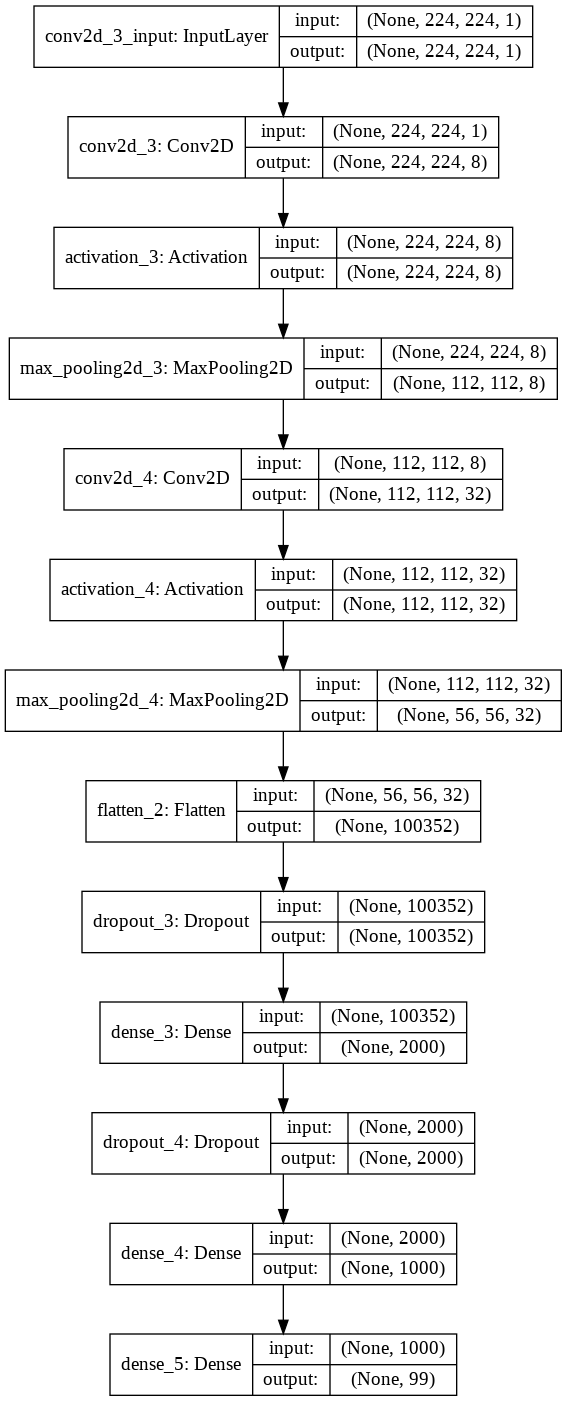

In [0]:
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History

cnn1 = Sequential()
cnn1.add(Convolution2D(8, (5, 5), input_shape=(224, 224, 1), border_mode='same'))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Convolution2D(32, 5, 5, border_mode='same'))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn1.add(Flatten())
cnn1.add(Dropout(0.15))
cnn1.add(Dense(2000, activation='relu'))
cnn1.add(Dropout(0.15))
cnn1.add(Dense(1000, activation='relu'))
cnn1.add(Dense(no_of_classes, activation='softmax'))

cnn1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

nb_epoch = 20
batch_size= 16

history = cnn1.fit(X_img_tr, y_tr, 
          nb_epoch=nb_epoch,
          validation_data=(X_img_val, y_val), 
          batch_size=batch_size)

plot_model(cnn1, show_shapes=True)

### Convolutional Neural Network with Image Augmnentation

In [0]:

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True
    )


# don't give better accuracy
cnn2 = Sequential()
cnn2.add(Convolution2D(8, (5, 5), input_shape=(224, 224, 1), border_mode='same'))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn2.add(Convolution2D(32, 5, 5, border_mode='same'))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn2.add(Flatten())
cnn2.add(Dropout(0.15))
cnn2.add(Dense(2000, activation='relu'))
cnn2.add(Dropout(0.15))
cnn2.add(Dense(1000, activation='relu'))
cnn2.add(Dense(no_of_classes, activation='softmax'))

cnn2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

nb_epoch = 20

cnn2.fit_generator(datagen.flow(X_img_tr, y_tr, batch_size=32), 
                   validation_data=(X_img_val, y_val),
                  steps_per_epoch=len(X_img_tr) / 32, 
                   epochs=nb_epoch)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(224, 224,..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`


Epoch 1/20
25/24 [==============================] - 6s 233ms/step - loss: 4.9010 - acc: 0.0038 - val_loss: 4.5888 - val_acc: 0.0101
Epoch 2/20
25/24 [==============================] - 3s 121ms/step - loss: 4.5937 - acc: 0.0038 - val_loss: 4.5876 - val_acc: 0.0101
Epoch 3/20
25/24 [==============================] - 3s 123ms/step - loss: 4.5888 - acc: 0.0100 - val_loss: 4.5649 - val_acc: 0.0101
Epoch 4/20
25/24 [==============================] - 3s 122ms/step - loss: 4.5467 - acc: 0.0125 - val_loss: 4.3584 - val_acc: 0.0354
Epoch 5/20
25/24 [==============================] - 3s 123ms/step - loss: 4.2986 - acc: 0.0142 - val_loss: 3.8918 - val_acc: 0.0354
Epoch 6/20
25/24 [==============================] - 3s 123ms/step - loss: 3.9436 - acc: 0.0479 - val_loss: 3.6395 - val_acc: 0.0657
Epoch 7/20
25/24 [==============================] - 3s 121ms/step - loss: 3.6606 - acc: 0.0463 - val_loss: 3.3266 - val_acc: 0.1061
Epoch 8/20
25/24 [==============================] - 3s 123ms/step - loss: 3.

### Convolutional Neural Network with low amount of Image Augmentation

In [0]:
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=0.5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range = 0.05
    )

cnn3 = Sequential()
cnn3.add(Convolution2D(8, (5, 5), input_shape=(224, 224, 1), border_mode='same'))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(Convolution2D(32, 5, 5, border_mode='same'))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn3.add(Flatten())
cnn3.add(Dropout(0.15))
cnn3.add(Dense(2000, activation='relu'))
cnn3.add(Dropout(0.15))
cnn3.add(Dense(1000, activation='relu'))
cnn3.add(Dense(no_of_classes, activation='softmax'))

cnn3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

nb_epoch = 20

cnn3.fit_generator(datagen.flow(X_img_tr, y_tr, batch_size=32), 
                   validation_data=(X_img_val, y_val),
                   steps_per_epoch=len(X_img_tr) / 32, 
                   epochs=nb_epoch)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(224, 224,..., padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  


Epoch 1/20
25/24 [==============================] - 6s 235ms/step - loss: 7.5137 - acc: 0.0113 - val_loss: 4.5933 - val_acc: 0.0101
Epoch 2/20
25/24 [==============================] - 3s 117ms/step - loss: 4.5954 - acc: 0.0125 - val_loss: 4.5936 - val_acc: 0.0303
Epoch 3/20
25/24 [==============================] - 3s 115ms/step - loss: 4.5905 - acc: 0.0325 - val_loss: 4.5491 - val_acc: 0.0303
Epoch 4/20
25/24 [==============================] - 3s 119ms/step - loss: 4.2240 - acc: 0.0537 - val_loss: 3.2455 - val_acc: 0.1566
Epoch 5/20
25/24 [==============================] - 3s 115ms/step - loss: 2.9916 - acc: 0.1871 - val_loss: 2.6355 - val_acc: 0.2626
Epoch 6/20
25/24 [==============================] - 3s 117ms/step - loss: 2.4089 - acc: 0.2733 - val_loss: 2.2419 - val_acc: 0.3485
Epoch 7/20
25/24 [==============================] - 3s 117ms/step - loss: 2.0557 - acc: 0.3888 - val_loss: 2.0591 - val_acc: 0.4293
Epoch 8/20
25/24 [==============================] - 3s 120ms/step - loss: 1.

# Transfer Learning VGG

### VGG with no Data Augmentation

Epoch 1/50
25/24 [==============================] - 3s 130ms/step - loss: 5.7402 - acc: 0.0250 - val_loss: 4.6149 - val_acc: 0.1010
Epoch 2/50
25/24 [==============================] - 3s 101ms/step - loss: 4.3593 - acc: 0.0954 - val_loss: 3.7958 - val_acc: 0.1111
Epoch 3/50
25/24 [==============================] - 3s 101ms/step - loss: 3.6315 - acc: 0.1542 - val_loss: 3.4164 - val_acc: 0.1616
Epoch 4/50
25/24 [==============================] - 3s 101ms/step - loss: 3.2107 - acc: 0.2421 - val_loss: 2.9760 - val_acc: 0.2626
Epoch 5/50
25/24 [==============================] - 3s 101ms/step - loss: 2.9171 - acc: 0.2792 - val_loss: 2.7345 - val_acc: 0.3081
Epoch 6/50
25/24 [==============================] - 3s 101ms/step - loss: 2.6725 - acc: 0.3208 - val_loss: 2.5596 - val_acc: 0.3788
Epoch 7/50
25/24 [==============================] - 3s 101ms/step - loss: 2.3554 - acc: 0.3886 - val_loss: 2.3319 - val_acc: 0.4040
Epoch 8/50
25/24 [==============================] - 3s 101ms/step - loss: 2.

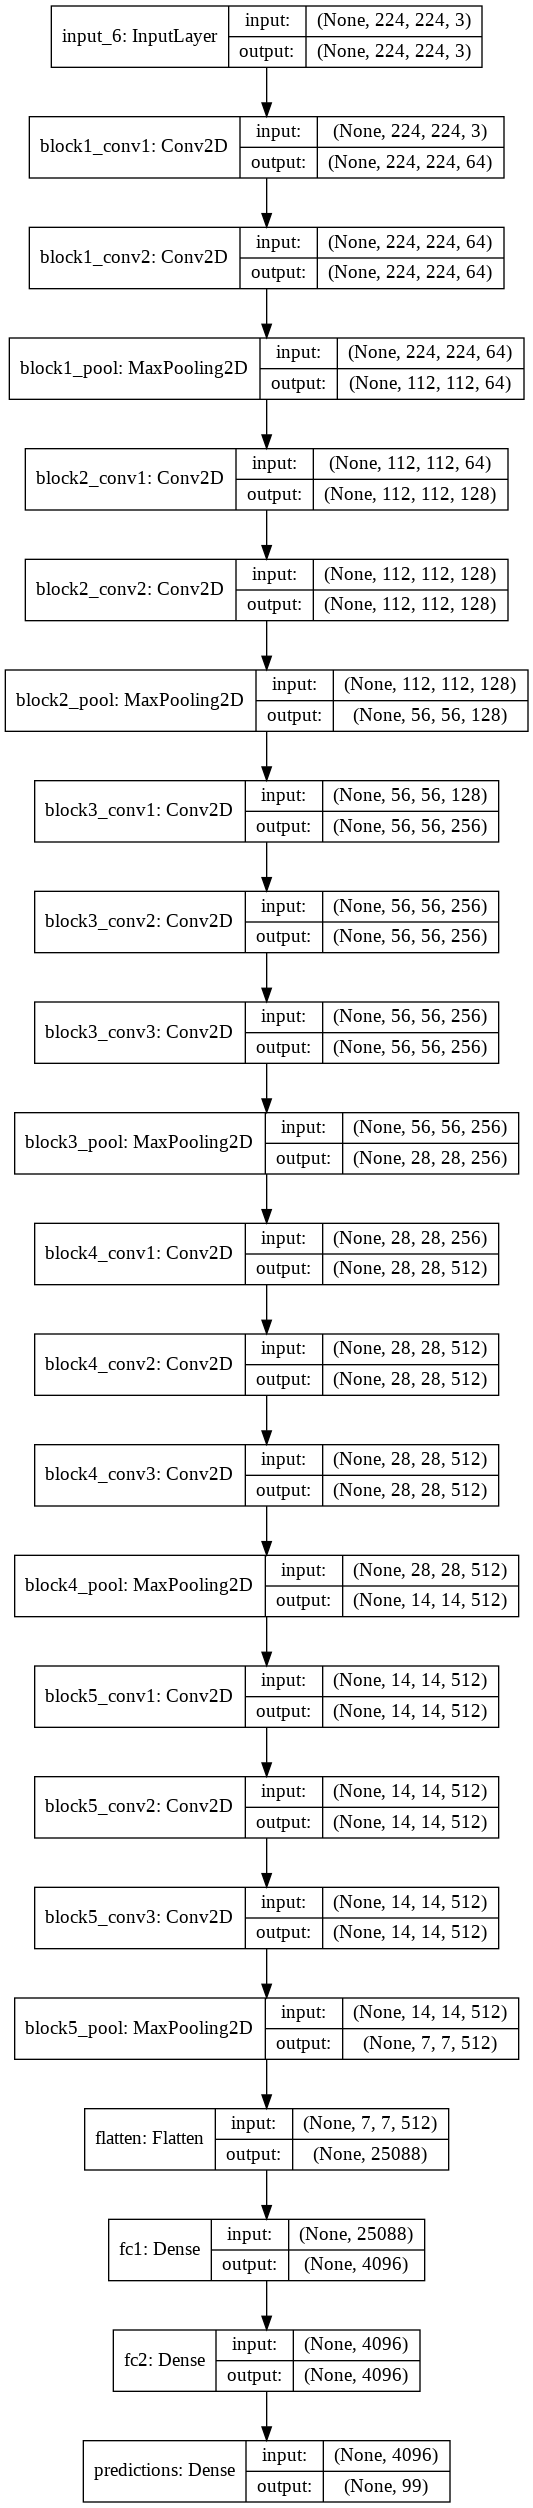

In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History


X_img_tr2 = np.repeat(X_img_tr, repeats = 3, axis = -1)
X_img_val2 = np.repeat(X_img_val, repeats = 3, axis = -1)

datagen = ImageDataGenerator()

vgg = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None)
for layer in vgg.layers: layer.trainable=False
x = vgg.layers[-2].output
output_layer = Dense(no_of_classes, activation='softmax', name='predictions')(x)
vgg2 = Model(inputs=vgg.input, outputs=output_layer)

vgg2.compile(optimizer=Adam(lr=0.001),
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

vgg2.fit_generator(datagen.flow(X_img_tr2, y_tr, batch_size=32), 
                   validation_data=(X_img_val2, y_val),
                   steps_per_epoch=len(X_img_tr) / 32, 
                   epochs=50)

plot_model(vgg2, show_shapes=True)

### VGG with Image Augmentation













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
25/24 [==============================] - 10s 385ms/step - loss: 5.7853 - acc: 0.0088 - val_loss: 4.6743 - val_acc: 0.0303
Epoch 2/50
25/24 [==============================] - 8s 326ms/step - loss: 4.5504 - acc: 0.0492 - val_loss: 4.0021 - val_acc: 0.1364
Epoch 3/50
25/24 [==============================] - 9s 344ms/step - loss: 4.1543 - acc: 0.1137 - val_loss: 3.7060 - val_acc: 0.1818
Epoch 4/50
25/24 [==============================] - 9s 351ms/step - loss: 3.6607 - acc: 0.1329 - val_loss: 3.3001 - val_acc: 0.1970
Epoch 5/50
25/24 [==============================] - 9s 355ms/step - loss: 3.4007 - acc: 0.2112 - val_loss: 2.9776 - val_acc: 0.3232
Epoch 6/50
25/24 [==============================] - 9s 344ms/step - loss: 3.2394 - acc: 0.2416 - val_loss: 2.7505 - val_acc: 0.3687
Epoch 7/50
25/24 [==============================] - 9s 346ms/step - loss: 2.9867 - acc: 0.2716 - va

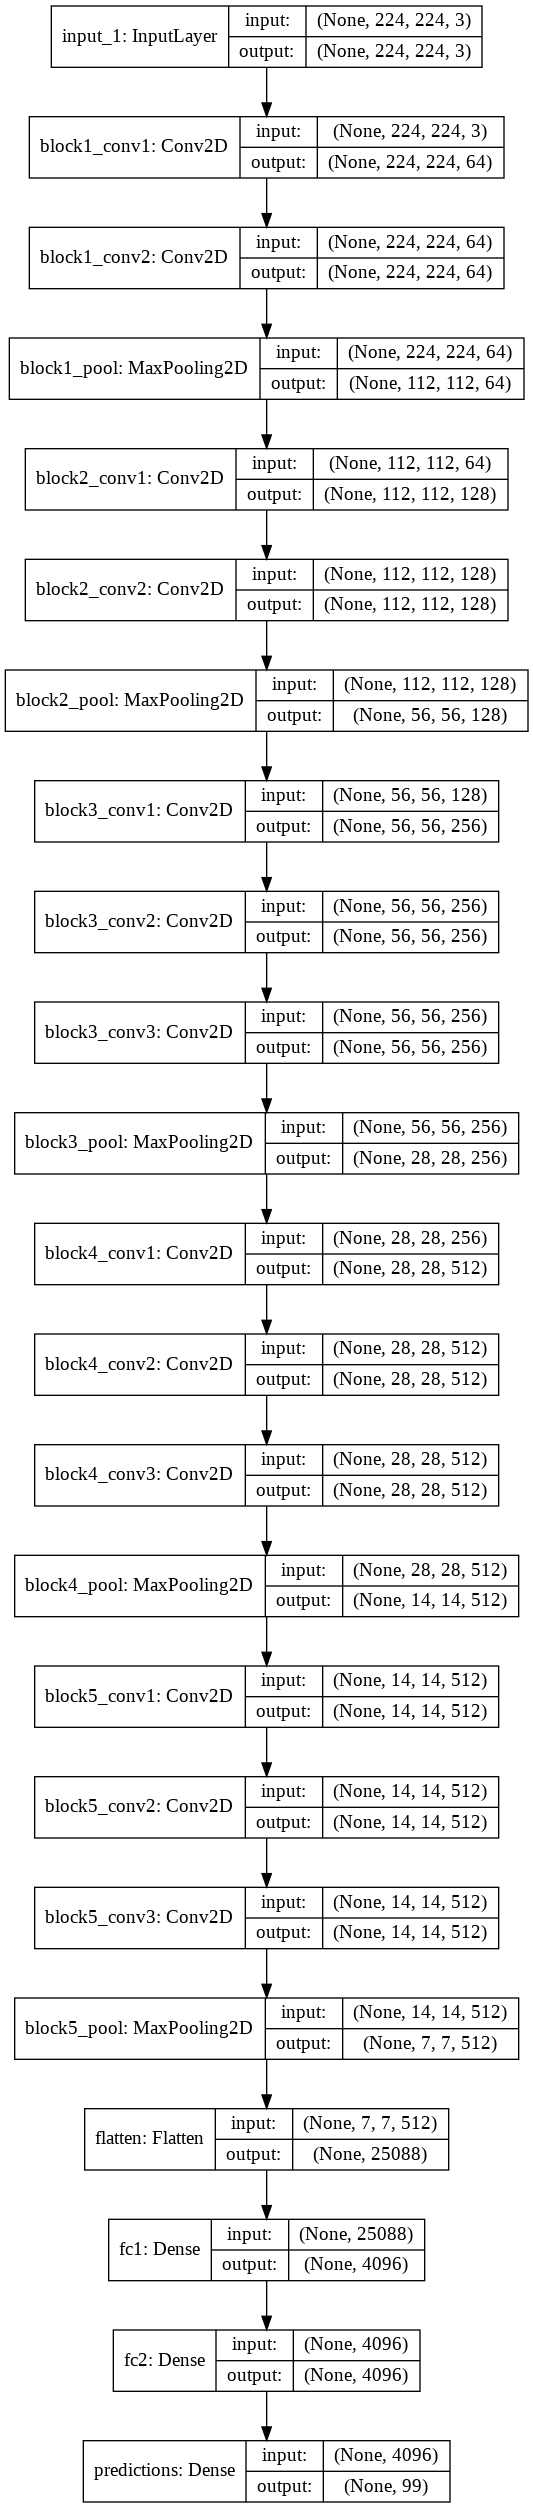

In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History


X_img_tr2 = np.repeat(X_img_tr, repeats = 3, axis = -1)
X_img_val2 = np.repeat(X_img_val, repeats = 3, axis = -1)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True
    )

vgg = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None)
for layer in vgg.layers: layer.trainable=False
x = vgg.layers[-2].output
output_layer = Dense(no_of_classes, activation='softmax', name='predictions')(x)
vgg2 = Model(inputs=vgg.input, outputs=output_layer)

vgg2.compile(optimizer=Adam(lr=0.001),
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

vgg2.fit_generator(datagen.flow(X_img_tr2, y_tr, batch_size=32), 
                   validation_data=(X_img_val2, y_val),
                   steps_per_epoch=len(X_img_tr) / 32, 
                   epochs=50)

plot_model(vgg2, show_shapes=True)

### VGG with little Data Augmentation













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
25/24 [==============================] - 10s 399ms/step - loss: 5.5366 - acc: 0.0192 - val_loss: 4.4994 - val_acc: 0.1111
Epoch 2/50
25/24 [==============================] - 7s 296ms/step - loss: 4.2890 - acc: 0.0900 - val_loss: 3.8788 - val_acc: 0.0859
Epoch 3/50
25/24 [==============================] - 8s 335ms/step - loss: 3.7207 - acc: 0.1496 - val_loss: 3.3915 - val_acc: 0.2172
Epoch 4/50
25/24 [==============================] - 8s 335ms/step - loss: 3.2977 - acc: 0.2212 - val_loss: 3.0039 - val_acc: 0.3182
Epoch 5/50
25/24 [==============================] - 8s 330ms/step - loss: 2.9317 - acc: 0.2812 - val_loss: 2.7150 - val_acc: 0.3131
Epoch 6/50
25/24 [==============================] - 8s 334ms/step - loss: 2.5872 - acc: 0.3620 - val_loss: 2.4665 - val_acc: 0.3788
Epoch 7/50
25/24 [==============================] - 8s 332ms/step - loss: 2.3630 - acc: 0.4063 - va

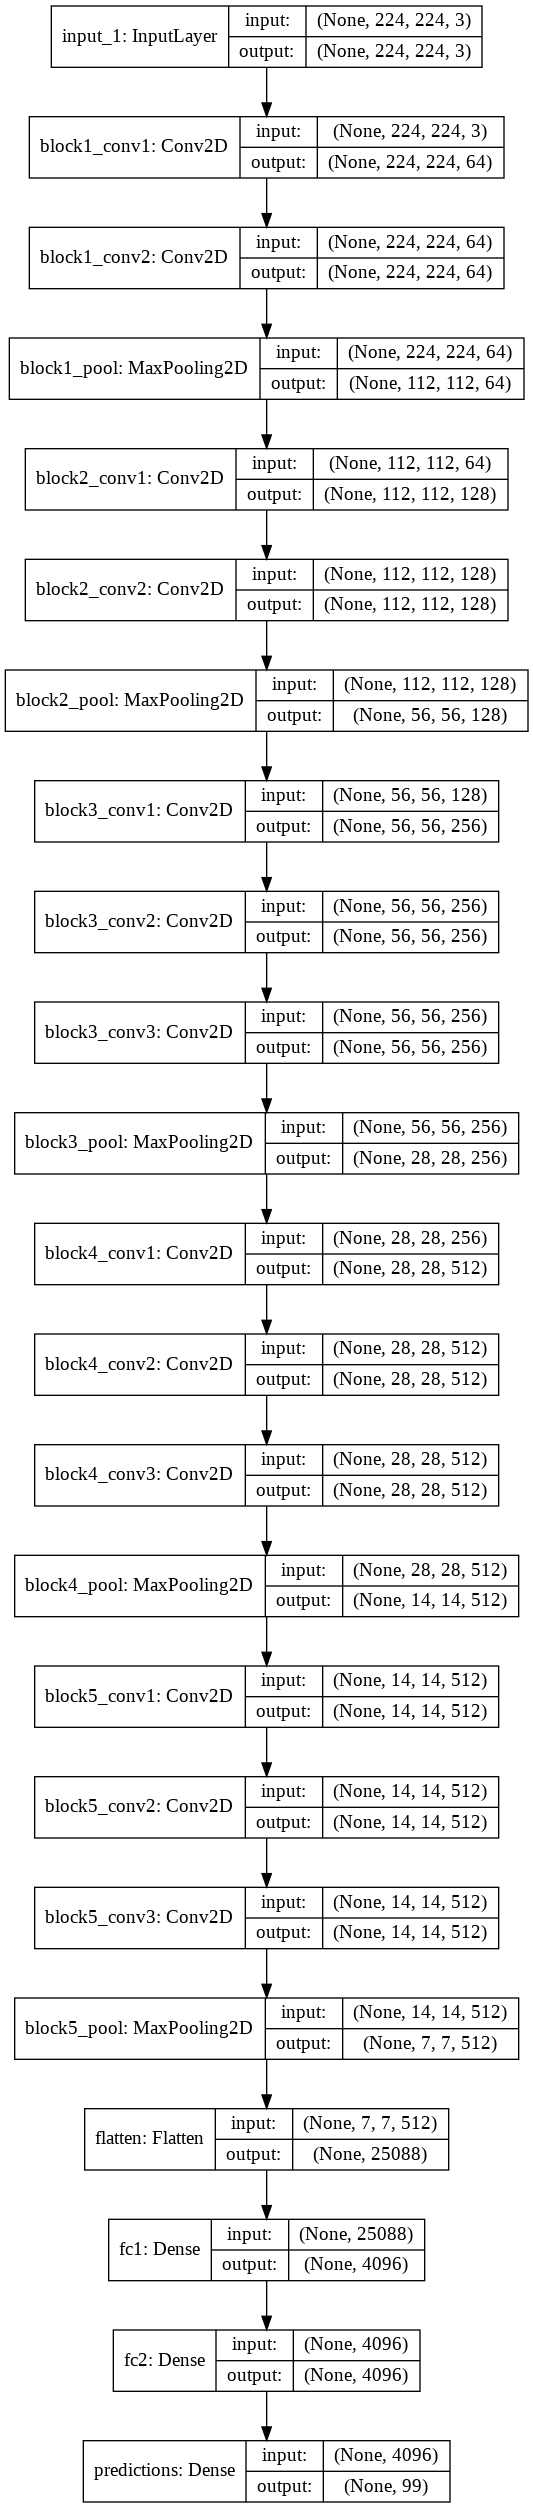

In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History



X_img_tr2 = np.repeat(X_img_tr, repeats = 3, axis = -1)
X_img_val2 = np.repeat(X_img_val, repeats = 3, axis = -1)

datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range = 0.05
    )

vgg = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None)
for layer in vgg.layers: layer.trainable=False
x = vgg.layers[-2].output
output_layer = Dense(no_of_classes, activation='softmax', name='predictions')(x)
vgg2 = Model(inputs=vgg.input, outputs=output_layer)

vgg2.compile(optimizer=Adam(lr=0.001),
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

vgg2.fit_generator(datagen.flow(X_img_tr2, y_tr, batch_size=32), 
                   validation_data=(X_img_val2, y_val),
                   steps_per_epoch=len(X_img_tr) / 32, 
                   epochs=50)

plot_model(vgg2, show_shapes=True)

# Merged Neural Neural Network


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(224, 224,..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 792 samples, validate on 198 samples
Epoch 1/100
792/792 [==============================] - 1s 2ms/step - loss: 3.7885 - acc: 0.2588 - val_loss: 1.2518 - val_acc: 0.8081
Epoch 2/100
792/792 [==============================] - 1s 885us/step - loss: 0.6353 - acc: 0.8384 - val_loss: 0.4853 - val_acc: 0.8838
Epoch 3/100
792/792 [==============================] - 1s 882us/step - loss: 0.1058 - acc: 0.9760 - val_loss: 0.7089 - val_acc: 0.8434
Epoch 4/100
792/792 [==============================] - 1s 879us/step - loss: 0.0628 - acc: 0.9861 - val_loss: 0.3335 - val_acc: 0.9091
Epoch 5/100
792/792 [==============================] - 1s 883us/step - loss: 0.0802 - acc: 0.9773 - val_loss: 0.4511 - val_acc: 0.8788
Epoch 6/100
792/792 [==============================] - 1s 880us/step - loss: 0.0475 - acc: 0.9886 - val_loss: 0.5754 - val_acc: 0.9192
Epoch 7/100
792/792 [==============================] - 1s 874us/step - loss: 0.0308 - acc: 0.9912 - val_loss: 0.3353 - val_acc: 0.9192
Epoch 8/100

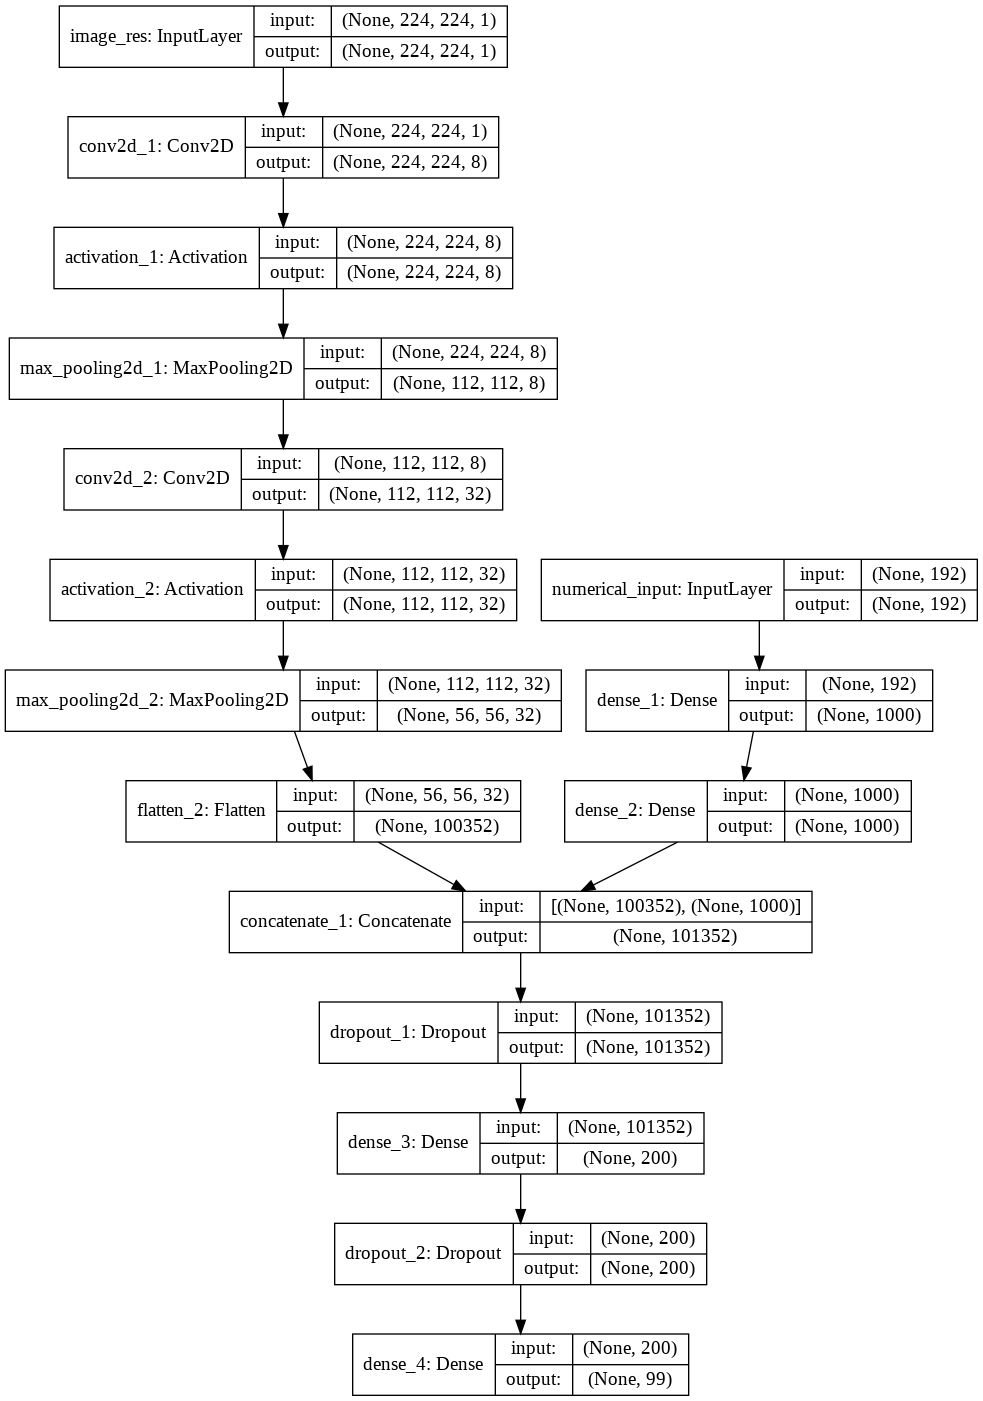

In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, concatenate
from keras.callbacks import History
from keras.layers import Input, Dense

image_res = Input(shape=(224, 224, 1), name='image_res')
conv_side = Convolution2D(8, 5, 5, input_shape=(224, 224, 1), border_mode='same')(image_res)
conv_side = (Activation('relu'))(conv_side)
conv_side = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(conv_side)
conv_side = (Convolution2D(32, 5, 5, border_mode='same'))(conv_side)
conv_side = (Activation('relu'))(conv_side)
conv_side = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(conv_side)

conv_side = Flatten()(conv_side)
numerical_input = Input(shape=(number_of_features,), name='numerical_input')
structured_side = Dense(1000, activation='tanh')(numerical_input)
structured_side = Dense(1000, activation='relu')(structured_side)

Merged_layers = concatenate([conv_side, structured_side])

final_layers = Dropout(.25)(Merged_layers)
final_layers = Dense(200, activation='relu')(final_layers)
final_layers = Dropout(.25)(final_layers)

output = Dense(no_of_classes, activation='softmax')(final_layers)
Merged_Model = Model(input=[image_res, numerical_input], output=output)

Merged_Model.compile(loss='sparse_categorical_crossentropy', 
                     optimizer='rmsprop', metrics=['accuracy'])


Merged_Model.fit([X_img_tr, X_num_tr], y_tr,
                              nb_epoch=100,
                              validation_data=([X_img_val, X_num_val], y_val),
                              verbose=1)

plot_model(Merged_Model, show_shapes=True)

# Autokeras

In [0]:
# !pip install autokeras
import autokeras as ak
# make sure you are using tensorflow 2.1.0 or newer!

### Autokeras with structured Data

In [0]:

clf = ak.StructuredDataClassifier(max_trials=20, objective='val_accuracy')

clf.fit(X_num_tr, y_tr, validation_data=(X_num_val, y_val))

predicted_y = clf.predict(X_num_val)

print(clf.evaluate(X_num_val, y_val))

predicted_y_tr = clf.predict(X_num_tr)
predicted_y_te = clf.predict(X_num_val)

import sklearn
acc_tr = sklearn.metrics.accuracy_score(y_tr, predicted_y_tr)
print(acc_tr)
acc_te = sklearn.metrics.accuracy_score(y_val, predicted_y_te)
print(acc_te)

### New Autokeras with unstructured Data

In [0]:
import autokeras as ak

clf = ak.ImageClassifier(max_trials=10)
clf.fit(X_img_tr, y_tr,  validation_data=(X_img_val, y_val))

predicted_y = clf.predict(X_img_te)

predicted_y_tr = clf.predict(X_img_tr)
predicted_y_te = clf.predict(X_img_val)

import sklearn
acc_tr = sklearn.metrics.accuracy_score(y_tr, predicted_y_tr)
print(acc_tr)
acc_te = sklearn.metrics.accuracy_score(y_val, predicted_y_te)
print(acc_te)


# Human Augmented Neural Network (HANN)


1.0
0.9949494949494949


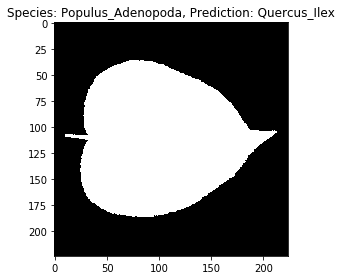

In [5]:
# Looking at Predictions of Val Data

predicted_y_tr = fully_conn1.predict_classes(X_num_tr)
predicted_y_val = fully_conn1.predict_classes(X_num_val)

import sklearn
# Show uncertain prediction
import matplotlib.pyplot as plt

acc_tr = sklearn.metrics.accuracy_score(y_tr, predicted_y_tr)
print(acc_tr)
acc_te = sklearn.metrics.accuracy_score(y_val, predicted_y_val)
print(acc_te)

species_predicted = []

true_species = []
for x in y_val:
  species = mapping[x]
  true_species.append(species)

for x in predicted_y_val:
  species = mapping[x]
  species_predicted.append(species)


# False Predictions for the Validation data
false = []
for x, species in enumerate(species_predicted):
  pred = species_predicted[x]
  spec = true_species[x]
  if pred != spec:
    false.append(x)
    false.append(spec)
    false.append(pred)
    imshow = plt.imshow #alias
    pic = X_img_val[x]
    plt.title("Species: %s, Prediction: %s" % (spec, pred))
    imshow(pic[:, :, 0], cmap='gray')
    plt.tight_layout()
  plt.show()



### HANN for Validation Data

In [0]:
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History

import matplotlib.pyplot as plt

def Human_Augmented_NN(X_num_tr, y_tr, X_num_val, y_val):

  seed = 5
  mod1 = Sequential()
  mod1.add(Dense(1000, activation='tanh', input_dim = X_num_tr.shape[1]))
  mod1.add(Dense(2000, activation='relu'))
  mod1.add(Dense(no_of_classes, activation='softmax'))

  mod1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

  mod1.fit(X_num_tr, y_tr, 
                  epochs = 20, 
                  verbose=1, 
                  validation_data=(X_num_val, y_val))

  ypred_val = mod1.predict_classes(X_num_val)
  ypob_val = mod1.predict_proba(X_num_val)

  acc_tr = sklearn.metrics.accuracy_score(y_val, ypred_val)
  print('Validation Accuracy before Human Augmentation: ', acc_tr)

  unsure = []

  ypred_te_adjusted = ypred_val

  for x, pred in enumerate(ypred_val):
    probs = ypob_val[x]
    top2_ind = probs.argsort()[-3:]
    prob2 = probs[top2_ind[1]]
    species2 = mapping[top2_ind[1]]
    prob1 = probs[top2_ind[2]]
    species1 = mapping[top2_ind[2]]
    prob3 = probs[top2_ind[0]]
    species3 = mapping[top2_ind[0]]
    if prob1<(3*(prob2+prob2)):
      print(x)
      unsure.append(x)
      unsure.append(species1)
      unsure.append(species2)
      imshow = plt.imshow #alias
      pic = X_img_val[x]
      plt.title("Prediction No. 1: %s, Prediction No. 2: %s" % (species1, species2))
      imshow(pic[:, :, 0], cmap='gray')
    
      indexes_spec1 = np.argwhere(y_full == top2_ind[2])
      fig, axs = plt.subplots(1,10, figsize=(22, 3))
      axs = axs.ravel()
      for k, ix in enumerate(indexes_spec1):
        pic = X_img_full[ix]
        fig.suptitle(species1)
        axs[k].imshow(pic[0,:, :, 0], cmap='gray') 
 
      indexes_spec2 = np.argwhere(y_full == top2_ind[1])
      fig, axs = plt.subplots(1,10, figsize=(22, 3))
      axs = axs.ravel()
      for k, ix in enumerate(indexes_spec2):
        pic = X_img_full[ix]
        fig.suptitle(species2)
        axs[k].imshow(pic[0,:, :, 0], cmap='gray')  

      indexes_spec3 = np.argwhere(y_full == top2_ind[0])
      fig, axs = plt.subplots(1,10, figsize=(22, 3))
      axs = axs.ravel()
      for k, ix in enumerate(indexes_spec3):
        pic = X_img_full[ix]
        fig.suptitle(species3)
        axs[k].imshow(pic[0,:, :, 0], cmap='gray')  
      plt.tight_layout()
      plt.show()
      answer = input('Top Mid or Bottom? ') 
      if answer.lower() == 'top':
       continue
      elif answer.lower() == 'mid':
       ypred_te_adjusted[x] = top2_ind[1]
      elif answer.lower() == 'bottom':
       ypred_te_adjusted[x] = top2_ind[0]
      else: print('Input not recognized')
    
      print('**********************************************************************************************************************************')
  
  X_num_full2 = np.concatenate((X_num_tr, X_num_val), axis =0)
  y_full2 = np.concatenate((y_tr, ypred_te_adjusted), axis =0)


  seed = 5
  mod2 = Sequential()
  mod2.add(Dense(1000, activation='tanh', input_dim = X_num_tr.shape[1]))
  mod2.add(Dense(2000, activation='relu'))
  mod2.add(Dense(no_of_classes, activation='softmax'))

  mod2.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

  mod2.fit(X_num_full2, y_full2, 
                  epochs = 50, 
                  verbose=1, 
                  validation_data=(X_num_val, y_val))

  pred_augmented = mod2.predict_classes(X_num_val)
  acc_tr = sklearn.metrics.accuracy_score(y_val, pred_augmented)
  print('Validation Accuracy After Human Augmentation: ', acc_tr)

  model_out = mod2
  return model_out, ypred_te_adjusted, ypred_val

Train on 792 samples, validate on 198 samples
Epoch 1/20
792/792 [==============================] - 0s 412us/step - loss: 1.9839 - acc: 0.5859 - val_loss: 0.4620 - val_acc: 0.8586
Epoch 2/20
792/792 [==============================] - 0s 105us/step - loss: 0.1397 - acc: 0.9646 - val_loss: 0.1674 - val_acc: 0.9596
Epoch 3/20
792/792 [==============================] - 0s 102us/step - loss: 0.0368 - acc: 0.9874 - val_loss: 0.0770 - val_acc: 0.9747
Epoch 4/20
792/792 [==============================] - 0s 100us/step - loss: 0.0103 - acc: 0.9962 - val_loss: 0.0546 - val_acc: 0.9899
Epoch 5/20
792/792 [==============================] - 0s 100us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9899
Epoch 6/20
792/792 [==============================] - 0s 100us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9899
Epoch 7/20
792/792 [==============================] - 0s 104us/step - loss: 0.0046 - acc: 0.9975 - val_loss: 0.0397 - val_acc: 0.9899
Epoch 8/20
792/7

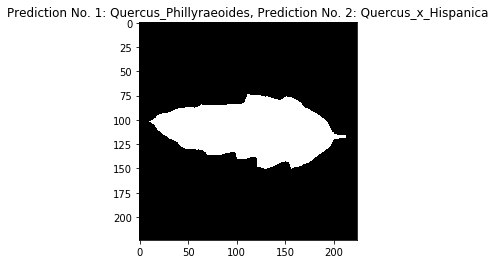

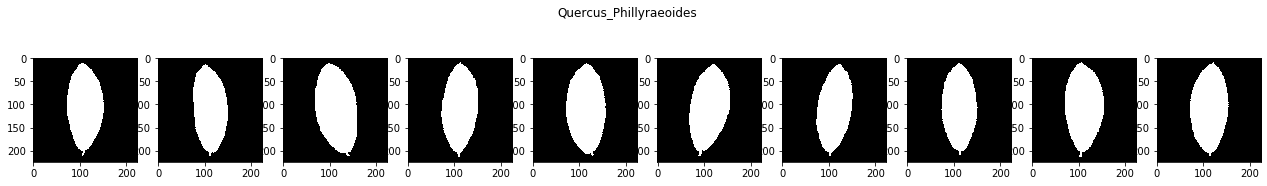

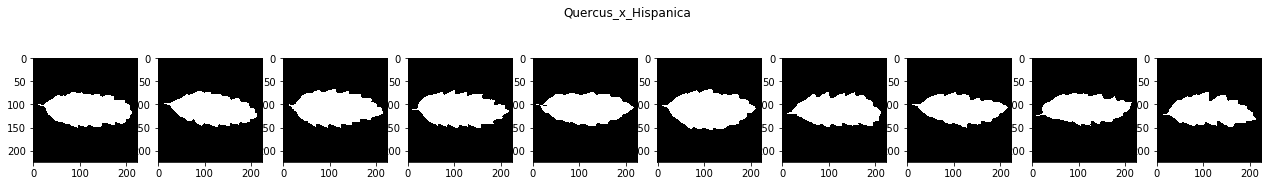

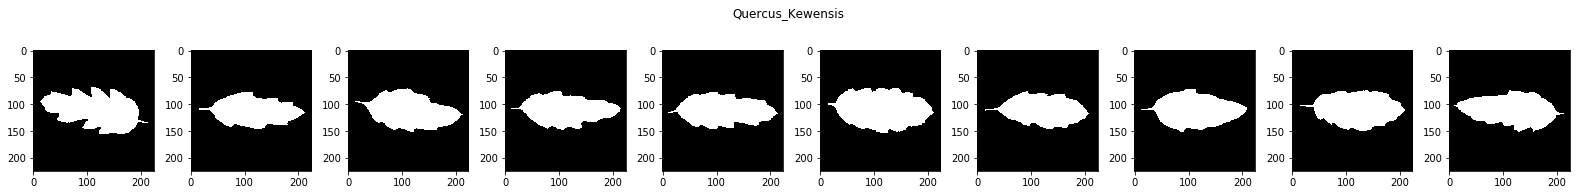

Top Mid or Bottom? bottom
**********************************************************************************************************************************
54


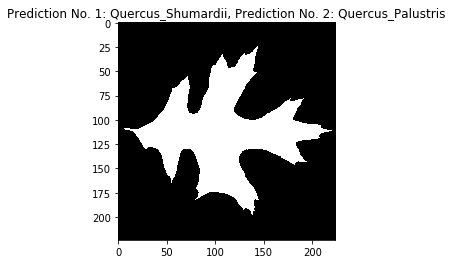

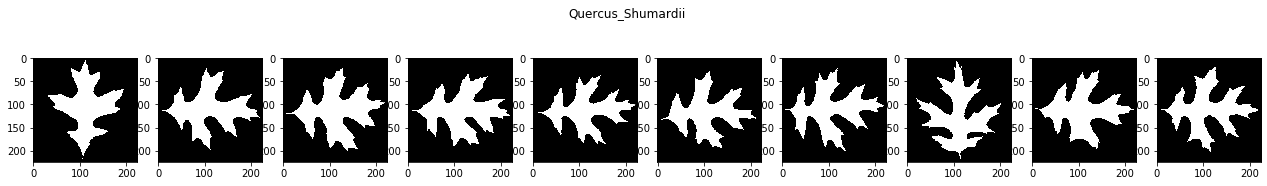

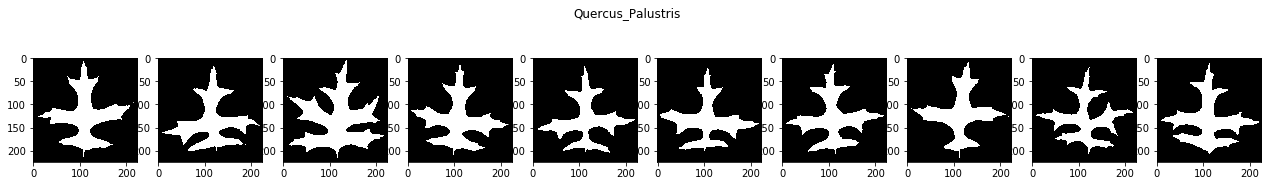

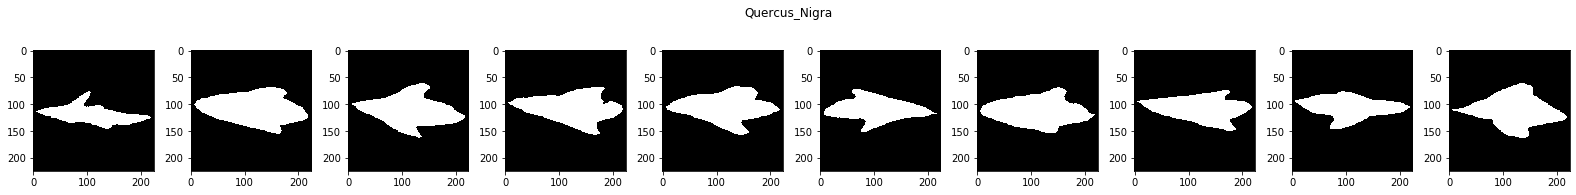

Top Mid or Bottom? top
61


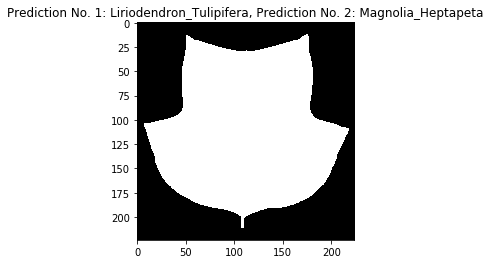

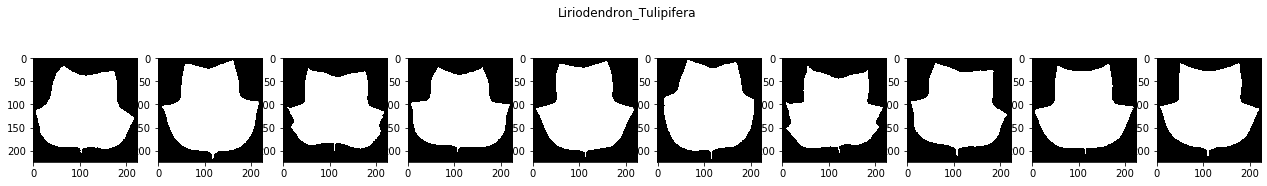

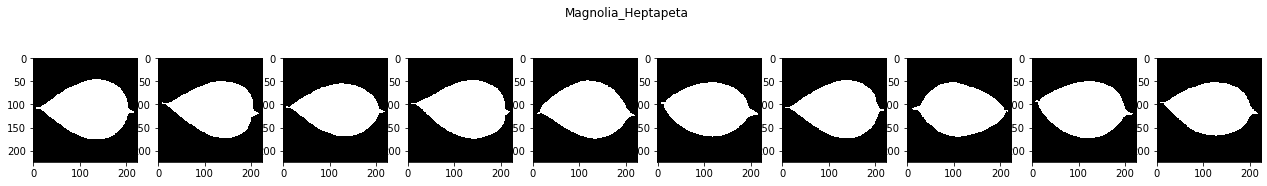

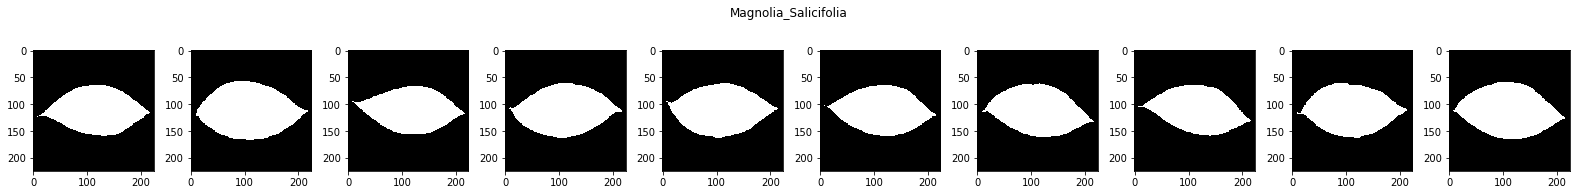

Top Mid or Bottom? top
104


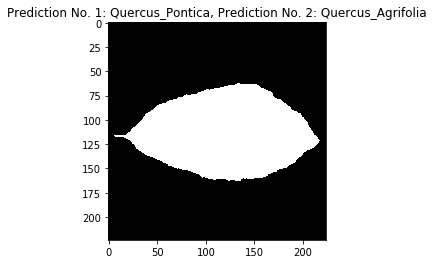

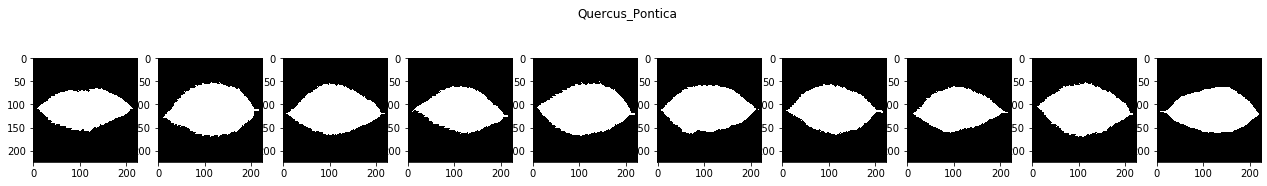

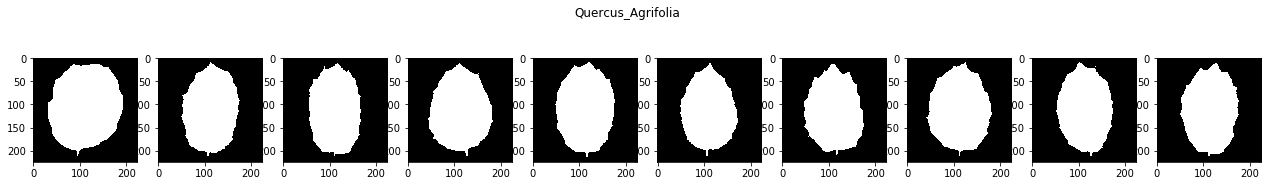

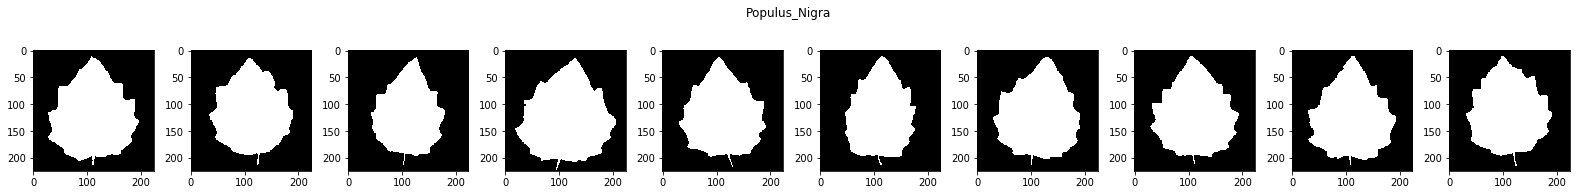

Top Mid or Bottom? top
143


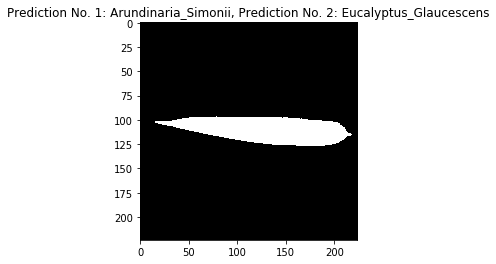

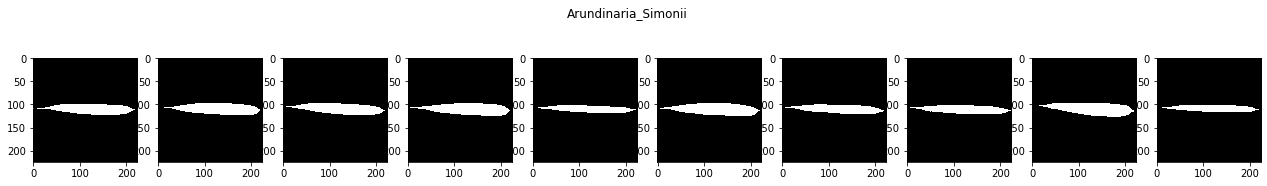

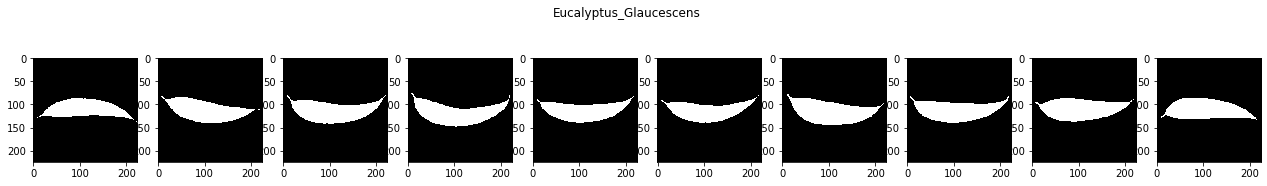

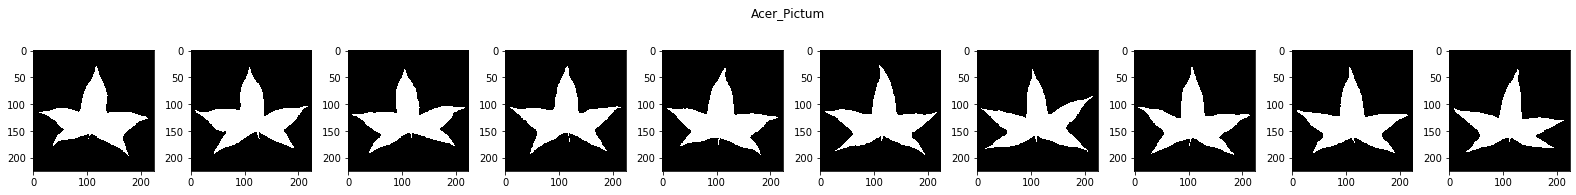

Top Mid or Bottom? top
177


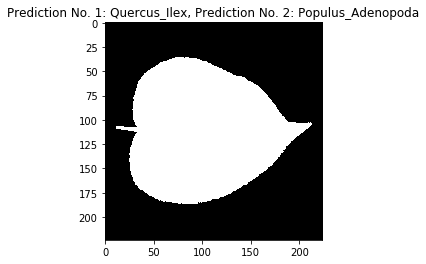

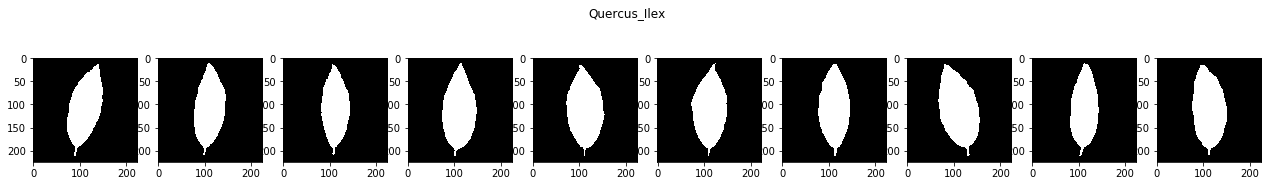

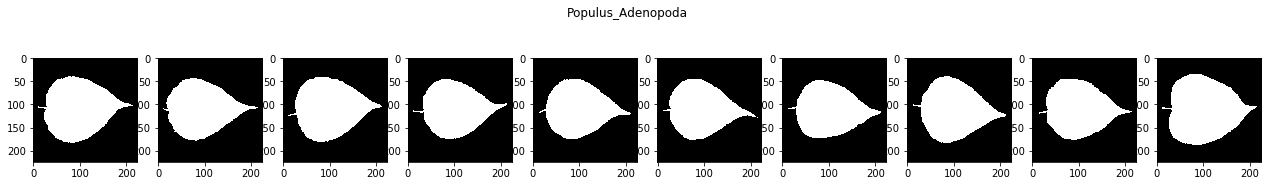

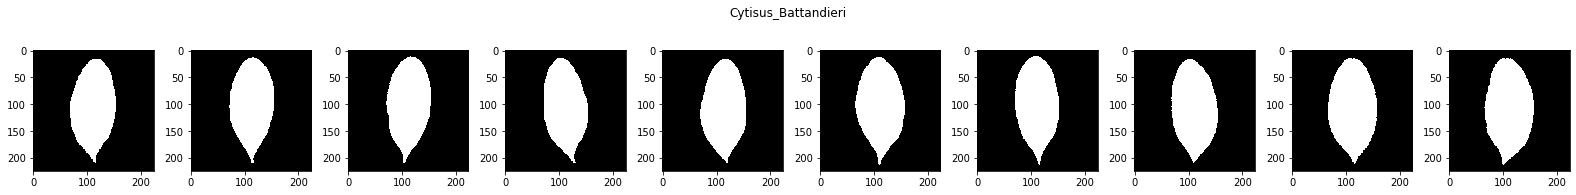

Top Mid or Bottom? mid
**********************************************************************************************************************************
Train on 990 samples, validate on 198 samples
Epoch 1/50
990/990 [==============================] - 0s 417us/step - loss: 1.5852 - acc: 0.6636 - val_loss: 0.1878 - val_acc: 0.9444
Epoch 2/50
990/990 [==============================] - 0s 104us/step - loss: 0.0904 - acc: 0.9727 - val_loss: 0.0853 - val_acc: 0.9899
Epoch 3/50
990/990 [==============================] - 0s 100us/step - loss: 0.0307 - acc: 0.9929 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 4/50
990/990 [==============================] - 0s 106us/step - loss: 0.0159 - acc: 0.9980 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 5/50
990/990 [==============================] - 0s 97us/step - loss: 0.0108 - acc: 0.9970 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 6/50
990/990 [==============================] - 0s 94us/step - loss: 0.0548 - acc: 0.9949 - val_loss: 0.0435 - val_acc: 0.989

In [8]:
mod, y_adj, y = Human_Augmented_NN(X_num_tr, y_tr, X_num_val, y_val)

# Predicting the Test Data with best Model

In [0]:
import sklearn
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import History

import matplotlib.pyplot as plt

def Human_Augmented_NN_for_test_prediction( X_num_full, y_full, X_num_te):

    seed = 5
    mod1 = Sequential()
    mod1.add(Dense(1000, activation='tanh', input_dim = X_num_full.shape[1]))
    mod1.add(Dense(2000, activation='relu'))
    mod1.add(Dense(no_of_classes, activation='softmax'))

    mod1.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

    mod1.fit(X_num_full, y_full, 
                  epochs = 20, 
                  verbose=1, 
                  validation_data=(X_num_val, y_val))

    ypred_te = mod1.predict_classes(X_num_te)
    ypob_te = mod1.predict_proba(X_num_te)

    unsure = []
    ypred_te_adjusted = ypred_te

    for x, pred in enumerate(ypred_te):
        probs = ypob_te[x]
        top2_ind = probs.argsort()[-10:]
        prob2 = probs[top2_ind[8]]
        species2 = mapping2[top2_ind[8]]
        prob1 = probs[top2_ind[9]]
        species1 = mapping2[top2_ind[9]]
        prob3 = probs[top2_ind[7]]
        species3 = mapping2[top2_ind[7]]
        species4 = mapping2[top2_ind[6]]
        prob4 = probs[top2_ind[6]]
        species5 = mapping2[top2_ind[5]]
        prob5 = probs[top2_ind[5]]
        prob6 = probs[top2_ind[4]]
        species6 = mapping2[top2_ind[4]]
        prob7 = probs[top2_ind[3]]
        species7 = mapping2[top2_ind[3]]
        prob8 = probs[top2_ind[2]]
        species8 = mapping2[top2_ind[2]]
        species9 = mapping2[top2_ind[1]]
        prob9 = probs[top2_ind[1]]
        species10 = mapping2[top2_ind[0]]
        prob10 = probs[top2_ind[0]]

        if prob1<(5*(prob2+prob3+prob4+prob5+prob6+prob7+prob8+prob9+prob10)):
            print(x)
            unsure.append(x)
            unsure.append(species1)
            unsure.append(species2)
            imshow = plt.imshow #alias
            pic = X_img_te[x]
            plt.title("Leaf of Question")
            imshow(pic[:, :, 0], cmap='gray')
    
            indexes_spec1 = np.argwhere(y_full == top2_ind[9])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec1):
                pic = X_img_full[ix]
                index = mapping[species1]
                title = str(1) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 
 
            indexes_spec2 = np.argwhere(y_full == top2_ind[8])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec2):
                pic = X_img_full[ix]
                index = mapping[species2]
                title = str(2) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray')  

            indexes_spec3 = np.argwhere(y_full == top2_ind[7])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec3):
                pic = X_img_full[ix]
                index = mapping[species3]
                title = str(3) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray')  

            indexes_spec4 = np.argwhere(y_full == top2_ind[6])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec4):
                pic = X_img_full[ix]
                index = mapping[species4]
                title = str(4) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 

            indexes_spec5 = np.argwhere(y_full == top2_ind[5])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec5):
                pic = X_img_full[ix]
                index = mapping[species5]
                title = str(5) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 

            indexes_spec6 = np.argwhere(y_full == top2_ind[4])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec6):
                pic = X_img_full[ix]
                index = mapping[species6]
                title = str(6) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray')
      
            indexes_spec7 = np.argwhere(y_full == top2_ind[3])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec7):
                pic = X_img_full[ix]
                index = mapping[species7]
                title = str(7) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 
      
            indexes_spec8 = np.argwhere(y_full == top2_ind[2])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec8):
                pic = X_img_full[ix]
                index = mapping[species8]
                title = str(8) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 
      
            indexes_spec9 = np.argwhere(y_full == top2_ind[1])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec9):
                pic = X_img_full[ix]
                index = mapping[species9]
                title = str(9) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 

            indexes_spec10 = np.argwhere(y_full == top2_ind[0])
            fig, axs = plt.subplots(1,10, figsize=(22, 3))
            axs = axs.ravel()
            for k, ix in enumerate(indexes_spec10):
                pic = X_img_full[ix]
                index = mapping[species10]
                title = str(10) + ' ' + ' position in Pred: ' + str(x) + ' Species_index: '+ str(index)
                fig.suptitle(title)
                axs[k].imshow(pic[0,:, :, 0], cmap='gray') 

            plt.tight_layout()
            plt.show()
            answer = input('Top Mid or Bottom? ') 
            if str(answer) == '1':continue
            elif str(answer) == '2':
                ypred_te_adjusted[x] = top2_ind[8]
            elif str(answer) == '3':
                ypred_te_adjusted[x] = top2_ind[7]
            elif str(answer) == '4':
                ypred_te_adjusted[x] = top2_ind[6]
            elif str(answer) == '5':
                ypred_te_adjusted[x] = top2_ind[5]
            elif str(answer) == '6':
                ypred_te_adjusted[x] = top2_ind[4]
            elif str(answer) == '7':
                ypred_te_adjusted[x] = top2_ind[3]
            elif str(answer) == '8':
                ypred_te_adjusted[x] = top2_ind[2]
            elif str(answer) == '9':
                ypred_te_adjusted[x] = top2_ind[1]
            elif str(answer) == '10':
                ypred_te_adjusted[x] = top2_ind[0]
            else: print('Input not recognized')
    
            print('**********************************************************************************************************************************')
  
    X_num_full2 = np.concatenate((X_num_full, X_num_te), axis =0)
    y_full2 = np.concatenate((y_full, ypred_te_adjusted), axis =0)

    seed = 5
    mod2 = Sequential()
    mod2.add(Dense(1000, activation='tanh', input_dim = X_num_tr.shape[1]))
    mod2.add(Dense(2000, activation='relu'))
    mod2.add(Dense(no_of_classes, activation='softmax'))

    mod2.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])
  
  #best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

    mod2.fit(X_num_te, ypred_te_adjusted, 
                  epochs = 50, 
                  verbose=1, 
                  validation_data=(X_num_te, ypred_te_adjusted)
                  #callbacks=[best_model]
           )

    y_te_pred_augmented = mod2.predict_classes(X_num_te)
  
    y_te_pred_augmented_tranlated = []

    for pred in y_te_pred_augmented:
        leaf = mapping2[pred]
        y_te_pred_augmented_tranlated.append(leaf)

    return mod2, ypred_te_adjusted,  y_te_pred_augmented_tranlated

Train on 990 samples, validate on 198 samples
Epoch 1/50
990/990 [==============================] - 0s 504us/step - loss: 1.6576 - acc: 0.6606 - val_loss: 0.1604 - val_acc: 0.9495
Epoch 2/50
990/990 [==============================] - 0s 105us/step - loss: 0.0957 - acc: 0.9788 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 3/50
990/990 [==============================] - 0s 98us/step - loss: 0.0303 - acc: 0.9939 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 4/50
990/990 [==============================] - 0s 97us/step - loss: 0.0126 - acc: 0.9970 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 5/50
990/990 [==============================] - 0s 99us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 6/50
990/990 [==============================] - 0s 115us/step - loss: 0.0189 - acc: 0.9970 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/50
990/990 [==============================] - 0s 101us/step - loss: 0.0082 - acc: 0.9980 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 8/50
990/990 

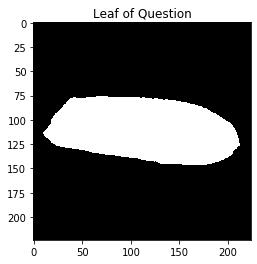

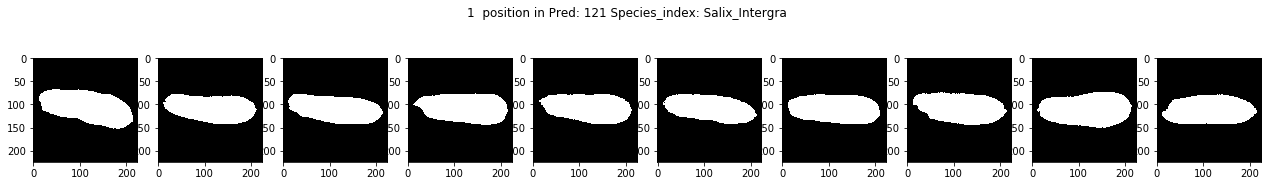

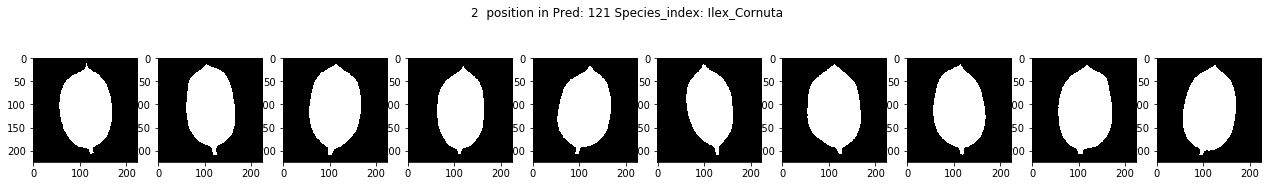

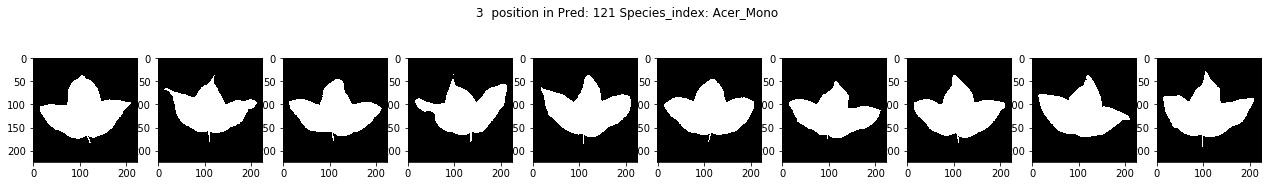

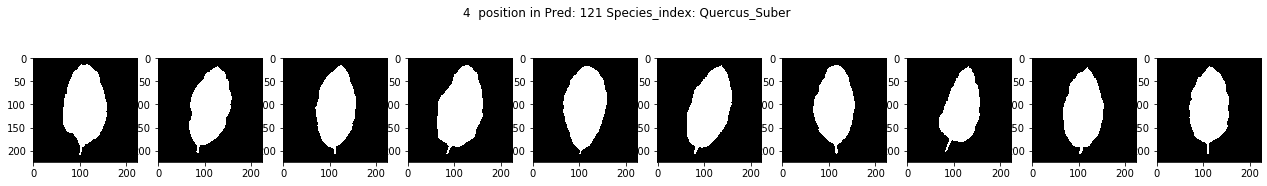

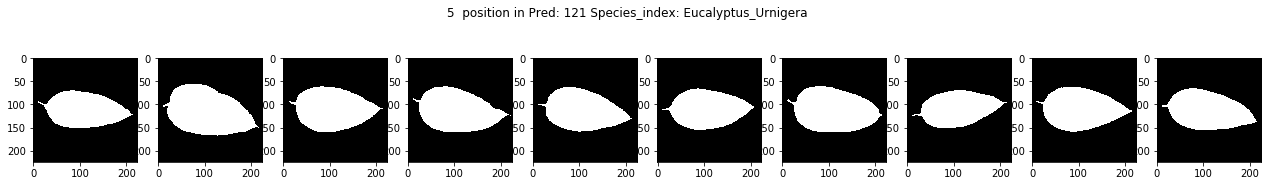

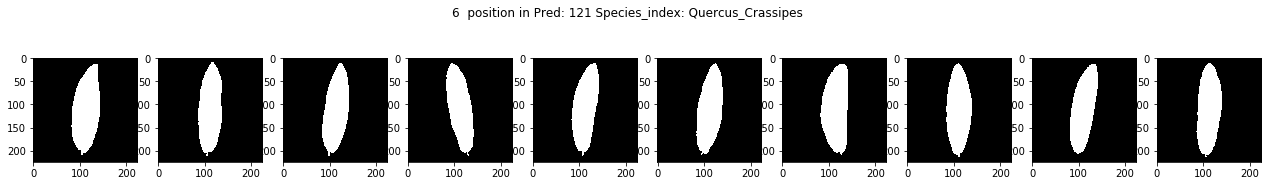

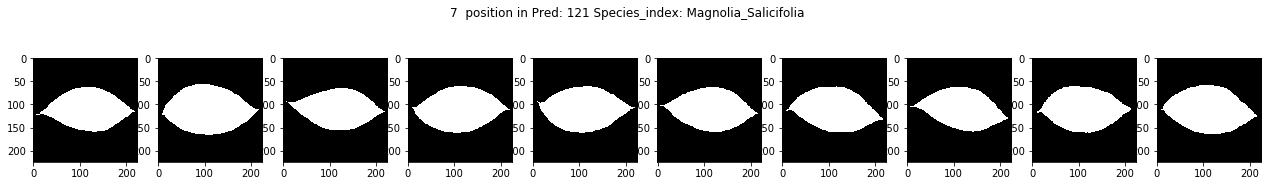

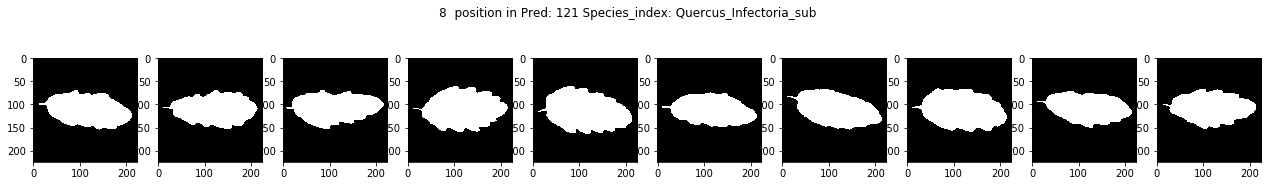

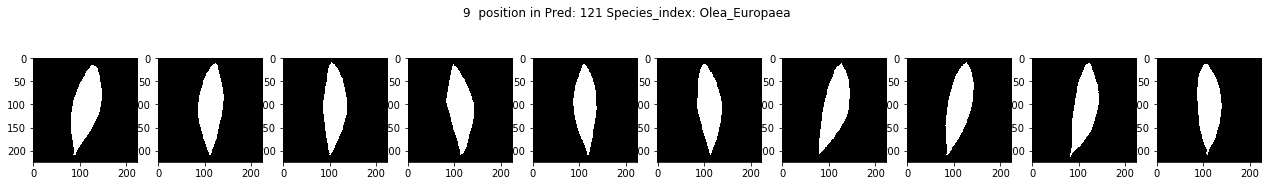

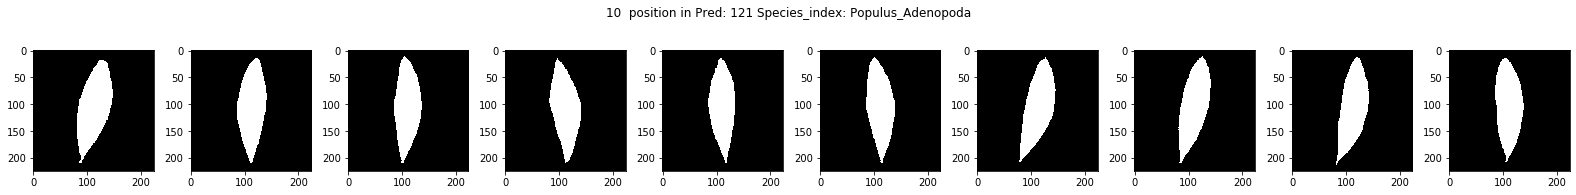

KeyboardInterrupt: ignored

In [12]:
model, y_aug, y_aug_trans =  Human_Augmented_NN_for_test_prediction( X_num_full, y_full, X_num_te)

In [0]:
import keras

# Save the model
model.save('Best_Leaf_Model.h5')


In [0]:
yPred_proba = model.predict(X_num_te)

# Converting the test predictions in a dataframe as depicted by sample submission
yPred = pd.DataFrame(yPred_proba,index=ID_te,columns=mapping.values())


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Creating and writing submission...
Finished writing submission


,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Crataegus_Monogyna,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,Magnolia_Heptapeta,...,Quercus_Coccinea,Quercus_Crassifolia,Quercus_Crassipes,Quercus_Dolicholepis,Quercus_Ellipsoidalis,Quercus_Greggii,Quercus_Hartwissiana,Quercus_Ilex,Quercus_Imbricaria,Quercus_Infectoria_sub,Quercus_Kewensis,Quercus_Nigra,Quercus_Palustris,Quercus_Phellos,Quercus_Phillyraeoides,Quercus_Pontica,Quercus_Pubescens,Quercus_Pyrenaica,Quercus_Rhysophylla,Quercus_Rubra,Quercus_Semecarpifolia,Quercus_Shumardii,Quercus_Suber,Quercus_Texana,Quercus_Trojana,Quercus_Variabilis,Quercus_Vulcanica,Quercus_x_Hispanica,Quercus_x_Turneri,Rhododendron_x_Russellianum,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1576,1.786910e-08,9.999845e-01,1.998935e-09,1.070882e-09,1.945272e-06,8.937096e-10,4.305621e-10,2.142817e-07,2.717936e-06,1.399710e-08,5.632088e-09,3.009609e-08,4.910748e-08,1.771638e-08,1.943809e-08,4.299824e-11,3.620161e-06,3.322135e-10,1.189101e-09,2.483337e-07,1.358002e-08,1.011740e-10,1.159447e-12,1.291524e-11,8.296792e-12,1.110797e-10,2.997298e-06,3.739058e-12,2.121556e-10,2.177989e-11,5.056488e-11,1.114216e-10,4.892565e-08,2.123099e-10,1.151750e-11,9.340010e-09,1.197393e-12,3.279294e-10,7.617374e-11,1.366656e-10,...,2.094664e-11,3.407833e-10,3.887086e-12,7.397107e-11,1.407417e-09,2.022533e-08,1.119736e-09,7.363857e-11,6.108133e-12,1.869190e-11,2.373037e-10,2.122138e-11,2.473454e-09,5.159186e-12,1.735537e-08,1.229364e-08,2.587199e-09,5.454859e-10,1.101655e-10,1.193755e-09,3.679617e-11,1.154001e-10,1.541154e-10,2.105970e-10,9.022626e-11,1.115476e-07,3.333629e-07,6.772174e-12,4.988359e-11,2.879232e-11,2.200603e-09,7.342458e-10,1.177703e-08,1.955159e-10,8.355173e-11,1.205521e-08,6.038100e-08,1.297622e-12,1.015286e-09,2.951549e-06
1577,2.310939e-08,7.453377e-07,2.634983e-10,6.877042e-07,3.888709e-09,8.370972e-10,7.281602e-09,9.232634e-07,9.398050e-06,5.578357e-09,1.740828e-08,3.674162e-07,9.999276e-01,1.520293e-06,1.117749e-07,4.527391e-10,1.279046e-08,8.010501e-06,1.282070e-08,1.318603e-06,7.606789e-08,3.672200e-11,2.848420e-11,1.106480e-10,1.915706e-10,1.501440e-10,1.115626e-07,2.212921e-12,4.145552e-10,8.773334e-11,4.411108e-10,4.695571e-11,1.141126e-08,9.615034e-09,1.298713e-11,9.330807e-09,5.411198e-12,1.077599e-09,6.512791e-11,4.517140e-12,...,1.385257e-11,5.792459e-09,2.478643e-11,2.294114e-08,1.846718e-09,2.102069e-07,2.116016e-07,1.555582e-10,1.381973e-10,4.397786e-09,8.078437e-09,1.079273e-09,8.661510e-09,4.297856e-12,3.764713e-09,7.315514e-09,5.601491e-10,2.678035e-10,6.302503e-10,3.787111e-09,1.597215e-08,2.405137e-09,1.423999e-09,5.750778e-10,1.808645e-09,1.256024e-08,6.908214e-07,1.109067e-08,3.832422e-10,1.473232e-11,1.576873e-09,2.873518e-10,5.708458e-06,5.742494e-09,3.069543e-06,9.469981e-08,1.205807e-07,5.537218e-12,1.004285e-09,9.498418e-06
1579,1.957178e-08,7.421966e-09,2.840580e-09,9.101399e-11,2.965320e-08,3.771417e-07,2.517088e-10,6.973077e-09,8.610329e-11,2.027821e-07,2.767706e-09,2.454666e-10,5.304486e-08,5.471237e-09,8.654988e-10,1.791613e-09,2.714493e-10,3.020448e-10,1.086284e-08,7.515526e-10,2.674852e-06,2.192804e-09,1.199009e-10,6.893209e-06,1.991946e-08,9.261515e-10,7.445645e-07,7.463596e-11,2.290732e-08,4.914243e-10,

In [0]:
# Make Predictions Binary
def haleemur(df):
    return df.apply(lambda x: x == x.max(), axis=1).astype(int)

In [0]:
yPred = haleemur(yPred)

In [0]:
yPred.to_csv('Our_Submissionn.csv')
